# Курсовой проект

* [Подготовка данных](#Подготовка-данных)
    * [Обзор данных](#Обзор-данных)
    * [Обработка выбросов и пропусков](#overfitting)
* [Анализ данных](#practice)
    * [Отбор признаков](#data_loading)
    * [Балансировка классов](#model_from_prev_lesson)
* [Построение модели](#overfitting)
    * [Подбор моделей](#overfitting)
    * [Финальная модель](#overfitting)
    * [Проверка качества](#overfitting)
    * [Интерпретация результатов](#overfitting)
* [Прогнозирование](#overfitting)
    
    
# Этапы

**Построение модели классификации**
1. Обзор обучающего датасета
2. Обработка выбросов
3. Обработка пропусков
4. Анализ данных
5. Отбор признаков
6. Балансировка классов
7. Подбор моделей, получение бейзлана
8. Выбор наилучшей модели, настройка гиперпараметров
9. Проверка качества, борьба с переобучением
10. Интерпретация результатов

**Прогнозирование на тестовом датасете**
1. Выполнить для тестового датасета те же этапы обработки и постронияния признаков
2. Спрогнозировать целевую переменную, используя модель, построенную на обучающем датасете
3. Прогнозы должны быть для всех примеров из тестового датасета (для всех строк)
4. Соблюдать исходный порядок примеров из тестового датасета

**Задача**

Требуется, на основании имеющихся данных о клиентах банка, построить модель, используя обучающий датасет, для прогнозирования невыполнения долговых обязательств по текущему кредиту. Выполнить прогноз для примеров из тестового датасета.

**Наименование файлов с данными**

course_project_train.csv - обучающий датасет<br>
course_project_test.csv - тестовый датасет

**Целевая переменная**

Credit Default - факт невыполнения кредитных обязательств

**Метрика качества**

F1-score (sklearn.metrics.f1_score)

**Требования к решению**

*Целевая метрика*
* F1 > 0.5 при Precision > 0.5 и Recall > 0.5
* Метрика оценивается по качеству прогноза для главного класса (1 - просрочка по кредиту)

*Решение должно содержать*
1. Тетрадка Jupyter Notebook с кодом Вашего решения, названная по образцу {ФИО}\_solution.ipynb, пример SShirkin\_solution.ipynb
2. Файл CSV с прогнозами целевой переменной для тестового датасета, названный по образцу {ФИО}\_predictions.csv, пример SShirkin\_predictions.csv

*Рекомендации для файла с кодом (ipynb)*
1. Файл должен содержать заголовки и комментарии (markdown)
2. Повторяющиеся операции лучше оформлять в виде функций
3. Не делать вывод большого количества строк таблиц (5-10 достаточно)
4. По возможности добавлять графики, описывающие данные (около 3-5)
5. Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
6. Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
7. Весь проект должен быть в одном скрипте (файл ipynb).
8. Допускается применение библиотек Python и моделей машинного обучения,
которые были в данном курсе.

**Сроки сдачи**

Cдать проект нужно в течение 5 дней после окончания последнего вебинара.
Оценки работ, сданных до дедлайна, будут представлены в виде рейтинга, ранжированного по заданной метрике качества.
Проекты, сданные после дедлайна или сданные повторно, не попадают в рейтинг, но можно будет узнать результат.

# Библиотеки и функции

In [441]:
import pandas as pd
import numpy as np
import pickle
import random

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

from sklearn.linear_model import LogisticRegression as lr
from sklearn.neighbors import KNeighborsClassifier as knn
from sklearn.ensemble import RandomForestClassifier as rfc
import xgboost as xgb
import catboost as catb


import seaborn as sns
from matplotlib import pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import warnings
warnings.simplefilter('ignore')

In [442]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [443]:
def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) 

In [444]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

In [445]:
def show_learning_curve_plot(estimator, X, y, cv=3, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, 
                                                            cv=cv, 
                                                            scoring='f1',
                                                            train_sizes=train_sizes, 
                                                            n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(15,8))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.title(f"Learning curves ({type(estimator).__name__})")
    plt.xlabel("Training examples")
    plt.ylabel("Score")     
    plt.legend(loc="best")
    plt.grid()
    plt.show()

In [446]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

In [891]:
cnt = lambda x: len(x.unique())

def cat_matrix(df, field, target):
    a = df[[field, target]]
    a['ID'] = a.index.tolist()
    b = a.pivot_table(values='ID', index=field, columns=target, aggfunc='count').reset_index()
    b.fillna(0, inplace=True)
    return b

def cat_stat(df, field, target):
    b = cat_matrix(df, field, target)
    b['Total'] = b[0] + b[1]
    b['%'] = b[1] / b['Total'] * 100
    
    total = {
        0: b[0].sum(), 
        1: b[1].sum(), 
        'Total': b['Total'].sum(),
        '%': b[1].sum() / b['Total'].sum() * 100,
        field: '-- Total --'
    }
    
    b = b.sort_values(by=['Total'], ascending=False).append(total, ignore_index=True).set_index(fld)
    for i in [0, 1, 'Total', '%']:
        b[i] = b[i].astype(int)
    b.index.name=''
    b.columns.name=fld
    return b

**Пути к директориям и файлам**

In [448]:
TRAIN_DATASET = 'course_project_train.csv'
TEST_DATASET = 'course_project_test.csv'

SCALER_PATH = 'scaler.pkl'
MODEL_PATH = 'model.pkl'

# Подготовка данных

**Описание датасета**

* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые льготы
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

In [449]:
df = pd.read_csv(TRAIN_DATASET)
dfBASE = df.copy()
df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.00,NaN,0.00,11.00,26.30,685960.00,1.00,nan,1.00,debt consolidation,Short Term,99999999.00,47386.00,7914.00,749.00,0
1,Own Home,1025487.00,10+ years,0.00,15.00,15.30,1181730.00,0.00,nan,0.00,debt consolidation,Long Term,264968.00,394972.00,18373.00,737.00,1
2,Home Mortgage,751412.00,8 years,0.00,11.00,35.00,1182434.00,0.00,nan,0.00,debt consolidation,Short Term,99999999.00,308389.00,13651.00,742.00,0
3,Own Home,805068.00,6 years,0.00,8.00,22.50,147400.00,1.00,nan,1.00,debt consolidation,Short Term,121396.00,95855.00,11338.00,694.00,0
4,Rent,776264.00,8 years,0.00,13.00,13.60,385836.00,1.00,nan,0.00,debt consolidation,Short Term,125840.00,93309.00,7180.00,719.00,0


**Выделение целевой переменной и групп признаков**

In [450]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
Home Ownership                  7500 non-null object
Annual Income                   5943 non-null float64
Years in current job            7129 non-null object
Tax Liens                       7500 non-null float64
Number of Open Accounts         7500 non-null float64
Years of Credit History         7500 non-null float64
Maximum Open Credit             7500 non-null float64
Number of Credit Problems       7500 non-null float64
Months since last delinquent    3419 non-null float64
Bankruptcies                    7486 non-null float64
Purpose                         7500 non-null object
Term                            7500 non-null object
Current Loan Amount             7500 non-null float64
Current Credit Balance          7500 non-null float64
Monthly Debt                    7500 non-null float64
Credit Score                    5943 non-null float64
Credit Default                  7

In [451]:
TARGET_NAME = 'Credit Default'
BASE_FEATURES = df.columns.drop(TARGET_NAME).tolist()
CAT_FEAURES = list(df.select_dtypes(include='object').columns)
NUMERIC_FEATURES = df.columns.drop(CAT_FEAURES + [TARGET_NAME]).tolist()

## Обзор данных

#### Баланс классов в целевой переменной

In [452]:
df[TARGET_NAME].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

#### Количественные признаки

In [453]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
df[NUMERIC_FEATURES].describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
count,5943.00,7500.00,7500.00,7500.00,7500.00,7500.00,3419.00,7486.00,7500.00,7500.00,7500.00,5943.00
mean,1366391.72,0.03,11.13,18.32,945153.73,0.17,34.69,0.12,11873177.45,289833.24,18314.45,1151.09
std,845339.20,0.27,4.91,7.04,16026216.67,0.50,21.69,0.35,31926122.97,317871.38,11926.76,1604.45
min,164597.00,0.00,2.00,4.00,0.00,0.00,0.00,0.00,11242.00,0.00,0.00,585.00
25%,844341.00,0.00,8.00,13.50,279229.50,0.00,16.00,0.00,180169.00,114256.50,10067.50,711.00
50%,1168386.00,0.00,10.00,17.00,478159.00,0.00,32.00,0.00,309573.00,209323.00,16076.50,731.00
75%,1640137.00,0.00,14.00,21.80,793501.50,0.00,50.00,0.00,519882.00,360406.25,23818.00,743.00
max,10149344.00,7.00,43.00,57.70,1304726170.00,7.00,118.00,4.00,99999999.00,6506797.00,136679.00,7510.00


In [454]:
pd.set_option('display.float_format', None)
df.corr()[TARGET_NAME][:-1]

Annual Income                  -0.101375
Tax Liens                       0.024368
Number of Open Accounts         0.028884
Years of Credit History        -0.020567
Maximum Open Credit            -0.014275
Number of Credit Problems       0.020088
Months since last delinquent    0.002598
Bankruptcies                    0.001648
Current Loan Amount            -0.226522
Current Credit Balance         -0.019522
Monthly Debt                    0.018480
Credit Score                    0.442050
Name: Credit Default, dtype: float64

#### Категориальные признаки

In [892]:
for fld in CAT_FEAURES:
    print('-'*70, '\n', cat_stat(df, fld, TARGET_NAME),'\n\n')

---------------------------------------------------------------------- 
 Home Ownership     0     1  Total   %
                                     
Home Mortgage   2721   916   3637  25
Rent            2201  1003   3204  31
Own Home         455   192    647  29
Have Mortgage     10     2     12  16
-- Total --     5387  2113   7500  28 


---------------------------------------------------------------------- 
 Years in current job     0     1  Total   %
                                           
10+ years             1688   644   2332  27
1 year                 557   243    800  30
2 years                512   193    705  27
< 1 year               443   195    638  30
3 years                450   170    620  27
5 years                371   145    516  28
4 years                338   131    469  27
6 years                302   124    426  29
7 years                285   111    396  28
8 years                247    92    339  27
9 years                194    65    259  25
-- Total --  

## Обработка выбросов и пропусков

In [743]:
df = dfBASE.copy()

### Выбросы

In [744]:
flds = ['Current Loan Amount', 'Maximum Open Credit', 'Current Credit Balance', 'Monthly Debt', 'Annual Income', 'Credit Score']
# plt.figure(figsize=(11,5))
# y = sns.boxplot(data=df[flds])
# y.set_yscale("log")
# y.set_xticklabels(y.get_xticklabels(), rotation=45)
# des = df.describe()
des[flds]

,Current Loan Amount,Maximum Open Credit,Current Credit Balance,Monthly Debt,Annual Income,Credit Score
count,7500.00,7500.00,7500.00,7500.00,5943.00,5943.00
mean,309088.03,557107.97,253853.83,17353.97,1299524.90,720.09
std,171393.74,382072.38,193851.46,9867.91,640926.52,27.96
min,11242.00,0.00,0.00,0.00,164597.00,585.00
25%,180169.00,279229.50,114256.50,10067.50,844341.00,708.00
50%,309567.50,478153.50,209313.50,16075.75,1168386.00,729.00
75%,396929.50,737214.50,338314.00,23022.75,1600873.50,740.00
max,789030.00,1992298.00,997899.00,49997.00,3997334.00,751.00


In [745]:
def fix_emissions(df):
    medians = dfBASE.median()
    
    em = [('Current Loan Amount', 1000000),
          ('Maximum Open Credit', 2000000),
          ('Current Credit Balance', 1000000),
          ('Monthly Debt', 50000),
          ('Annual Income', 4000000),
         ]
    
    for i in em:
        fld, more = i
        bad = df[fld] > more
        df.loc[bad, fld] = medians[fld]

    # Errors in Credit Score
    bad = df['Credit Score'] > 5000
    df.loc[bad, 'Credit Score'] = df.loc[bad, 'Credit Score'] / 10

fix_emissions(df)

### Пропуски

In [847]:
a = len(df) - df.count()
a[a != 0]

Series([], dtype: int64)

Очень большой процент пропущенных значений для поля Months since last delinquent есть гипотеза что это поле может быть связано с полями Bankruptcies и Number of Credit Problems попробуем проанализировать и заполнить

In [845]:
a = "Months since last delinquent"
b = "Bankruptcies"
c = "Number of Credit Problems"
fill = df.pivot_table(a, b, c, aggfunc=np.min)
pivot = df.pivot_table(a, b, c, aggfunc=cnt)
# sns.heatmap(fill, annot=True)
# sns.heatmap(pivot)
plt.show()

Большой процент пропущенных значений для поля Annual Income есть гипотеза что это поле может быть связано с полями относящимися к выданному кредиту попробуем проанализировать и заполнить

In [846]:
flds = ['Current Loan Amount', 'Maximum Open Credit', 'Current Credit Balance', 
        'Monthly Debt', 'Annual Income', 'Years of Credit History',
        'Number of Open Accounts']
# sns.heatmap(df[flds].corr())
plt.show()

# хорошая корреляция с полем Monthly Debt будем использвать его для заполнения
a = df[(~df['Annual Income'].isnull()) & (df['Credit Default']==0) & (df['Monthly Debt'] > 0)]
a = source['Annual Income'] / source['Monthly Debt']
ANNUAL_INCOME_MUL = float(a.mode())

Большой процент пропущенных значений для поля Credit Score есть гипотеза что это поле может быть связано с полями относящимися к выданному кредиту попробуем проанализировать и заполнить

In [832]:
flds = ['Annual Income', 'Credit Score', 'Years of Credit History']
flt = (~df['Annual Income'].isnull()) & (~df['Credit Score'].isnull()) & (df['Credit Default'] == 0)
# sns.relplot(y='Credit Score', x='Annual Income', hue='Years of Credit History', data=df[flt])

# из графика видно что нет никакой зависимости будем использовать median для заполнения

CREDIT_SCORE_DEFAULT = float(df[flt]['Credit Score'].median())

In [841]:
def fix_empty(df):
    df['Bankruptcies'].fillna(0, inplace=True)

    fld = 'Months since last delinquent'
    bad = (df[fld].isnull()) & ((df['Bankruptcies']>0) | (df['Number of Credit Problems'] > 0))
    df.loc[bad, fld] = 1
    df[fld].fillna(0, inplace=True)
    
    ifAnual = df['Years in current job'].isnull() & df['Annual Income'] > 0
    df.loc[ifAnual, 'Years in current job'] = '1 year'
    df['Years in current job'].fillna('< 1 year', inplace=True)

    fld = 'Annual Income'
    bad = df[fld].isnull()
    df.loc[bad, fld] = df.loc[bad, 'Monthly Debt'] * ANNUAL_INCOME_MUL
    
    fld = 'Credit Score'
    bad = df[fld].isnull()
    df.loc[bad, fld] = CREDIT_SCORE_DEFAULT

fix_empty(df)

In [843]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
df[NUMERIC_FEATURES].describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
count,7500.00,7500.00,7500.00,7500.00,7500.00,7500.00,7500.00,7500.00,7500.00,7500.00,7500.00,7500.00
mean,1292526.29,0.03,11.13,18.32,557107.97,0.17,15.89,0.12,309088.03,253853.83,17353.97,722.56
std,658929.07,0.27,4.91,7.04,382072.38,0.50,22.60,0.35,171393.74,193851.46,9867.91,25.35
min,0.00,0.00,2.00,4.00,0.00,0.00,0.00,0.00,11242.00,0.00,0.00,585.00
25%,830765.08,0.00,8.00,13.50,279229.50,0.00,0.00,0.00,180169.00,114256.50,10067.50,715.00
50%,1168329.00,0.00,10.00,17.00,478153.50,0.00,1.00,0.00,309567.50,209313.50,16075.75,732.00
75%,1618484.32,0.00,14.00,21.80,737214.50,0.00,29.00,0.00,396929.50,338314.00,23022.75,738.00
max,3997334.00,7.00,43.00,57.70,1992298.00,7.00,118.00,4.00,789030.00,997899.00,49997.00,751.00


In [848]:
pd.set_option('display.float_format', None)

## Отбор признаков

In [893]:
# for cat_colname in df.select_dtypes(include='object').columns[1:]:
#     df = pd.concat([df, pd.get_dummies(df[cat_colname], prefix=cat_colname)], axis=1)

In [897]:
CAT_FEAURES
# cat_matrix(df, 'Home Ownership', TARGET_NAME)

['Home Ownership', 'Years in current job', 'Purpose', 'Term']

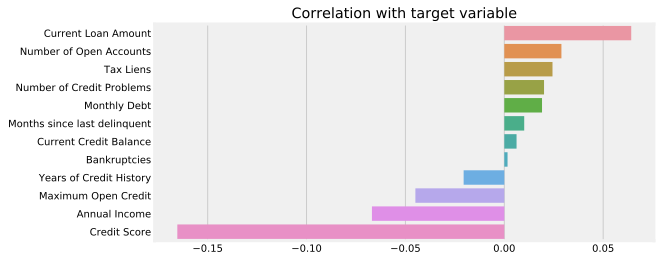

In [883]:
corr_with_target = df.corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(8, 4))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

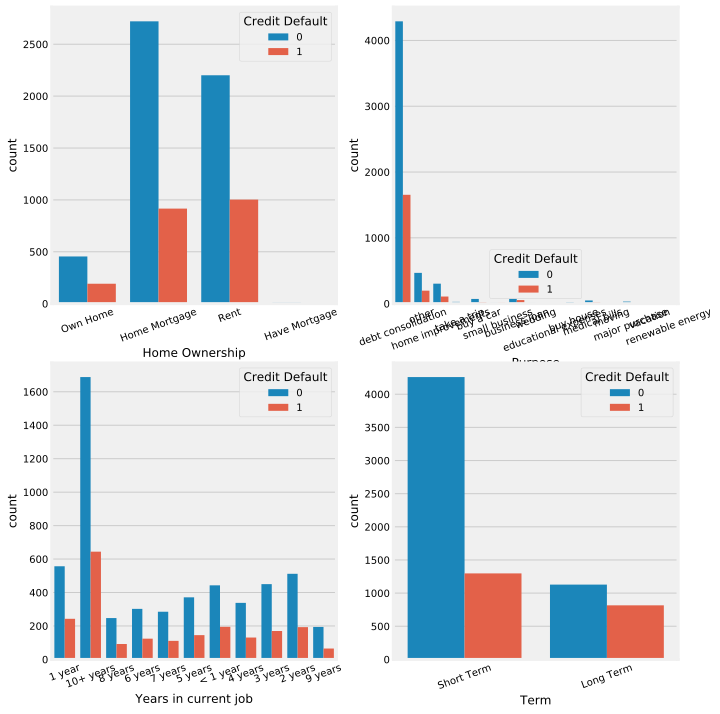

In [907]:
plt.figure(figsize=(10, 12))

ax = plt.subplot(221)
sns.countplot(x="Home Ownership", hue=TARGET_NAME, data=df)
ax.set_xticklabels(ax.get_xticklabels(), rotation=20)
ax = plt.subplot(222)
sns.countplot(x="Purpose", hue=TARGET_NAME, data=df)
ax.set_xticklabels(ax.get_xticklabels(), rotation=20)
ax = plt.subplot(223)
sns.countplot(x="Years in current job", hue=TARGET_NAME, data=df)
ax.set_xticklabels(ax.get_xticklabels(), rotation=20)
ax = plt.subplot(224)
sns.countplot(x="Term", hue=TARGET_NAME, data=df)
ax.set_xticklabels(ax.get_xticklabels(), rotation=20)
plt.show()

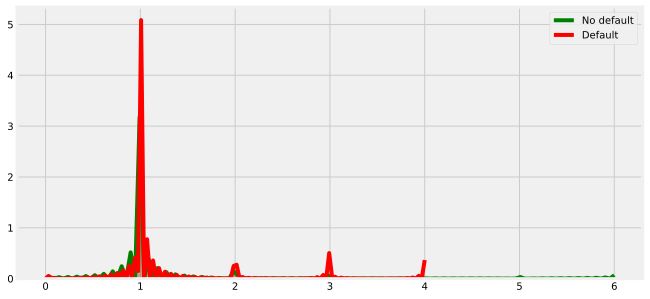

(0.4839591383934021, 0.0)

In [880]:
# df['Number of Open Accounts]
# sns.countplot(x="Number of Open Accounts", hue=TARGET_NAME, data=df)
#plt.legend(title='Target', loc='upper right')
#plt.show()

fld = 'Current Loan Amount'
fld = 'Credit Score'
fld = 'Number of Credit Problems'
a = df[[fld, TARGET_NAME]].sample(1000)
b = a[fld]
b_0 = b[a[TARGET_NAME] == 0]
b_1 = b[a[TARGET_NAME] == 1]

plt.figure(figsize=(10, 5))
sns.kdeplot(b_0, shade=True, label='No default', color='g')
sns.kdeplot(b_1, shade=True, label='Default', color='r')
plt.show()

from scipy.stats import shapiro
from scipy.stats import probplot
from scipy.stats import ttest_ind, mannwhitneyu
from scipy.stats import chi2_contingency
from statsmodels.stats.weightstats import zconfint

shapiro(a)

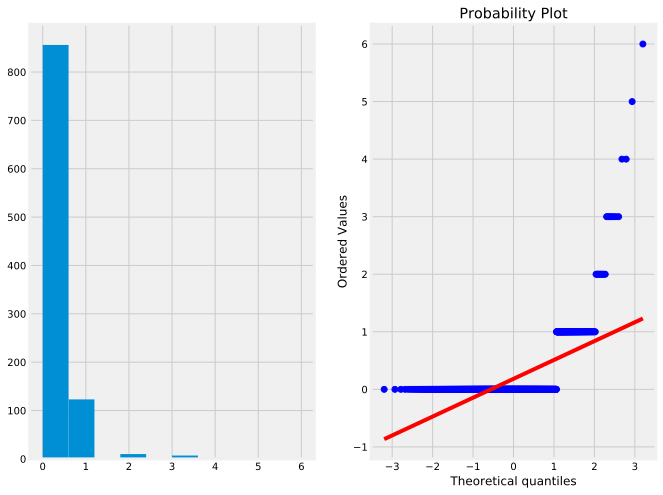

MannwhitneyuResult(statistic=95760.0, pvalue=0.021806098417280647)

In [885]:
plt.figure(figsize=(10, 8))

ax1 = plt.subplot(121)
b.hist()

plt.subplot(122)
probplot(b, dist='norm', plot=plt)

plt.show()
mannwhitneyu(b_0, b_1)

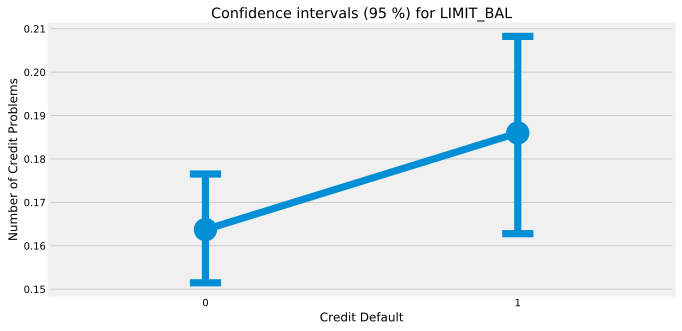

In [886]:
plt.figure(figsize=(10, 5))

sns.pointplot(x=TARGET_NAME, y=fld, data=df, capsize=.1)

plt.title('Confidence intervals (95 %) for LIMIT_BAL')
plt.show()

In [786]:
id = 'Annual Income'

source = df[~df[id].isnull()].copy()
target = source[id]
source = source[flds].drop(id, axis=1)
source
train, valid, train_price, valid_price = train_test_split(source, target, test_size=0.3, random_state=42)

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score as r2

model = LinearRegression(normalize=True)
model.fit(train, train_price)

predict = model.predict(valid)
r2(predict, valid_price)
predict
# train_amount = train['Current Loan Amount']
# train = train[feats]

# predict = a[a['Current Loan Amount'] > 99999990][feats]


# predict = predict['CLA'].astype(int).astype(float)
# a = a.merge(predict, how="left", left_index=True, right_index=True)
# bad = a['Current Loan Amount'] > 99999990
# a.loc[bad, 'Current Loan Amount'] = a.loc[bad, 'CLA']
# df[~bad].corr()['Current Loan Amount']



array([1297802.40460424,  874543.54218122, 1126340.29353362, ...,
       1133797.16733729, 1024543.56096031, 1119457.8328872 ])

In [404]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [627]:
# a = df.copy()
# fld = 'Months since last delinquent'

# sns.boxplot(x=fld, data=a)
# sns.swarmplot(x=fld, data=a, color=".25")
# b = df[~df['Months since last delinquent'].isnull()]['Credit Default'].value_counts()
# b[1]/b[0]

# много Months since last delinquent пропущенных значений но 
bad = df['Months since last delinquent'].isnull()
df.loc[bad, 'Months since last delinquent'] = 0

In [616]:
# a = df[df['Maximum Open Credit'] < 2000000]
# a = df[(df['Maximum Open Credit'] > 793501) | (df['Maximum Open Credit'] < 1)]


a = df.copy()
fld = ['Current Loan Amount']

# a = a[a[fld]>100]

# sns.boxplot(data=a)
# sns.swarmplot(x=fld, data=a, color=".25")
a.describe()


,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5943.00,7500.00,7500.00,7500.00,7500.00,7500.00,3419.00,7486.00,7500.00,7500.00,7500.00,5943.00,7500.00
mean,1299524.90,0.03,11.13,18.32,557107.97,0.17,34.69,0.12,309088.03,253853.83,17353.97,720.09,0.28
std,640926.52,0.27,4.91,7.04,382072.38,0.50,21.69,0.35,171393.74,193851.46,9867.91,27.96,0.45
min,164597.00,0.00,2.00,4.00,0.00,0.00,0.00,0.00,11242.00,0.00,0.00,585.00,0.00
25%,844341.00,0.00,8.00,13.50,279229.50,0.00,16.00,0.00,180169.00,114256.50,10067.50,708.00,0.00
50%,1168386.00,0.00,10.00,17.00,478153.50,0.00,32.00,0.00,309567.50,209313.50,16075.75,729.00,0.00
75%,1600873.50,0.00,14.00,21.80,737214.50,0.00,50.00,0.00,396929.50,338314.00,23022.75,740.00,1.00
max,3997334.00,7.00,43.00,57.70,1992298.00,7.00,118.00,4.00,789030.00,997899.00,49997.00,751.00,1.00


In [621]:
# sns.catplot(x="Annual Income", y="Current Loan Amount", 
#             # hue="Credit Default", # col="gender", 
#             kind="box", data=df);

# sns.relplot(x="Annual Income", y="Current Loan Amount", data=df)

# a = df.copy()
# a = a[a['Current Loan Amount'] < 99999999]
# a.boxplot(column='Current Loan Amount')

# plt.hist(a['Current Loan Amount'])


# df.boxplot(column='Monthly Debt')
# a = df[(df['Monthly Debt']<70000) & (df['Monthly Debt']>2000) & (df['Current Loan Amount'] < 99999999) & (df['Credit Default'] == 0)]

# a['MX'] = a[['Current Credit Balance','Current Loan Amount']].max(axis=1)


a = df.copy()
a['ID'] = a.index.tolist()
flds = ['Current Loan Amount', 'Maximum Open Credit', 'Current Credit Balance', 
        'Monthly Debt', 'Annual Income', 'Credit Score', 'Credit Default',
       'Months since last delinquent']

flt = ~a['Months since last delinquent'].isnull()

a[flt]

# train = a[a['Current Loan Amount'] < 99999999]
# train_amount = train['Current Loan Amount']
# train = train[feats]

# predict = a[a['Current Loan Amount'] > 99999990][feats]

# from sklearn.linear_model import LinearRegression
# model = LinearRegression(normalize=True)
# model.fit(train, train_amount)
# predict['CLA'] = model.predict(predict)

# predict = predict['CLA'].astype(int).astype(float)
# a = a.merge(predict, how="left", left_index=True, right_index=True)
# bad = a['Current Loan Amount'] > 99999990
# a.loc[bad, 'Current Loan Amount'] = a.loc[bad, 'CLA']
# df[~bad].corr()['Current Loan Amount']

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,ID
6,Home Mortgage,1511108.00,10+ years,0.00,9.00,20.30,388124.00,0.00,73.00,0.00,home improvements,Short Term,309573.00,51623.00,2317.00,745.00,0,6
7,Rent,1040060.00,10+ years,0.00,13.00,12.00,330374.00,0.00,18.00,0.00,other,Short Term,250888.00,89015.00,19761.00,705.00,1,7
9,Home Mortgage,nan,1 year,0.00,10.00,24.60,511302.00,0.00,6.00,0.00,debt consolidation,Long Term,572880.00,205333.00,17613.00,nan,1,9
18,Home Mortgage,1401744.00,2 years,0.00,9.00,29.00,387222.00,0.00,40.00,0.00,debt consolidation,Long Term,553586.00,201989.00,13434.00,695.00,1,18
20,Home Mortgage,1651993.00,10+ years,0.00,11.00,26.50,663894.00,0.00,44.00,0.00,debt consolidation,Long Term,585090.00,252852.00,8742.00,697.00,0,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7489,Home Mortgage,1394942.00,10+ years,0.00,15.00,27.20,1441396.00,0.00,35.00,0.00,debt consolidation,Short Term,753764.00,496698.00,16972.00,742.00,1,7489
7490,Own Home,1368000.00,10+ years,0.00,20.00,26.70,897842.00,0.00,69.00,0.00,debt consolidation,Short Term,683650.00,517199.00,29868.00,688.00,1,7490
7491,Home Mortgage,2833185.00,6 years,0.00,18.00,21.30,280170.00,0.00,6.00,0.00,debt consolidation,Short Term,437404.00,108889.00,16076.50,704.00,0,7491
7493,Rent,1257610.00,8 years,0.00,14.00,16.50,821480.00,0.00,58.00,0.00,debt consolidation,Long Term,448052.00,167428.00,27562.00,676.00,1,7493


In [371]:
b = df.copy()
b.loc[bad, 'Current Loan Amount'] = b.loc[bad, 'Current Credit Balance']
b.corr()['Current Loan Amount']

Annual Income                   0.431981
Tax Liens                       0.019966
Number of Open Accounts         0.209789
Years of Credit History         0.154574
Maximum Open Credit             0.029603
Number of Credit Problems      -0.073534
Months since last delinquent   -0.041453
Bankruptcies                   -0.099800
Current Loan Amount             1.000000
Current Credit Balance          0.500107
Monthly Debt                    0.437278
Credit Score                    0.015083
Credit Default                  0.054568
Name: Current Loan Amount, dtype: float64

In [373]:
b = df.copy()
b.loc[bad, 'Current Loan Amount'] = b[~bad].mean()
b.corr()['Current Loan Amount']

Annual Income                   0.457887
Tax Liens                       0.031811
Number of Open Accounts         0.214093
Years of Credit History         0.151634
Maximum Open Credit             0.019015
Number of Credit Problems      -0.064557
Months since last delinquent   -0.029173
Bankruptcies                   -0.096416
Current Loan Amount             1.000000
Current Credit Balance          0.368589
Monthly Debt                    0.438284
Credit Score                    0.017601
Credit Default                  0.066139
Name: Current Loan Amount, dtype: float64

In [324]:
cat_stat(df, 'Years in current job', TARGET_NAME)

Years in current job,0,1,Total,%
,,,,
10+ years,1688,644,2332,27
1 year,557,243,800,30
2 years,512,193,705,27
< 1 year,443,195,638,30
3 years,450,170,620,27
5 years,371,145,516,28
4 years,338,131,469,27
6 years,302,124,426,29
7 years,285,111,396,28


In [249]:
fld = 'Years in current job'
target = 'Annual Income'

a = df.copy()
a = a[[fld, target]]
# a['ID'] = a.index.tolist()


b = a.pivot_table(index=fld, aggfunc=np.median)
# ['ID'].reset_index()
# b.fillna(0, inplace=True)
# b['Total'] = b[0] + b[1]
# b['%'] = b[1] / b['Total'] * 100
b

,Annual Income
Years in current job,
1 year,1023330.5
10+ years,1327473.0
2 years,1080492.0
3 years,1159494.0
4 years,1163968.5
5 years,1137121.5
6 years,1155257.0
7 years,1159313.5
8 years,1249269.0


In [245]:
df[(df[fld] == 'UNKNOWN') & (df['Years of Credit History']>20)]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,UNKNOWN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
22,Rent,463790.0,UNKNOWN,0.0,6.0,28.3,288442.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,157700.0,5063.0,738.0,0
24,Own Home,NaN,UNKNOWN,0.0,12.0,25.0,1216336.0,0.0,61.0,0.0,debt consolidation,Short Term,467676.0,818311.0,37530.0,NaN,0
58,Home Mortgage,992845.0,UNKNOWN,0.0,17.0,21.2,1132054.0,0.0,NaN,0.0,debt consolidation,Short Term,207812.0,294291.0,25483.0,739.0,0
98,Rent,1242087.0,UNKNOWN,0.0,17.0,20.6,613954.0,1.0,36.0,1.0,debt consolidation,Short Term,196130.0,181336.0,16251.0,711.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7282,Own Home,569373.0,UNKNOWN,0.0,12.0,34.7,560032.0,0.0,33.0,0.0,debt consolidation,Short Term,109890.0,74005.0,8351.0,7480.0,1
7342,Home Mortgage,1343509.0,UNKNOWN,0.0,16.0,36.4,1308076.0,0.0,NaN,0.0,debt consolidation,Short Term,466686.0,512886.0,21944.0,750.0,0
7413,Rent,1784537.0,UNKNOWN,0.0,11.0,20.1,269676.0,0.0,13.0,0.0,debt consolidation,Short Term,449196.0,204250.0,22307.0,736.0,1
7439,Home Mortgage,671270.0,UNKNOWN,0.0,12.0,20.6,263406.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,151278.0,6937.0,737.0,0


In [202]:
a = df.copy()
a[a['Home Ownership']=='Home Mortgage'] 

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
6,Home Mortgage,1511108.0,10+ years,0.0,9.0,20.3,388124.0,0.0,73.0,0.0,home improvements,Short Term,99999999.0,51623.0,2317.0,745.0,0
8,Home Mortgage,NaN,5 years,0.0,17.0,15.7,0.0,1.0,NaN,1.0,home improvements,Short Term,129734.0,19.0,17.0,NaN,0
9,Home Mortgage,NaN,1 year,0.0,10.0,24.6,511302.0,0.0,6.0,0.0,debt consolidation,Long Term,572880.0,205333.0,17613.0,NaN,1
10,Home Mortgage,NaN,< 1 year,0.0,7.0,11.5,256322.0,0.0,NaN,0.0,debt consolidation,Short Term,220858.0,187492.0,14592.0,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7489,Home Mortgage,1394942.0,10+ years,0.0,15.0,27.2,1441396.0,0.0,35.0,0.0,debt consolidation,Short Term,753764.0,496698.0,16972.0,742.0,1
7491,Home Mortgage,2833185.0,6 years,0.0,18.0,21.3,280170.0,0.0,6.0,0.0,debt consolidation,Short Term,437404.0,108889.0,61150.0,704.0,0
7492,Home Mortgage,NaN,10+ years,0.0,10.0,13.3,423984.0,0.0,NaN,0.0,debt consolidation,Short Term,332948.0,161481.0,20966.0,NaN,0
7496,Home Mortgage,1533984.0,1 year,0.0,10.0,26.5,686312.0,0.0,43.0,0.0,debt consolidation,Long Term,444048.0,456399.0,12783.0,7410.0,1


In [220]:
a = df[df['Years in current job'].isnull()]
cat_stat(a, 'Term', TARGET_NAME)

KeyError: 'ID'

In [62]:
# for cat_colname in df.select_dtypes(include='object').columns:
#     print(str(cat_colname) + '\n\n' + str(df[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')
    

# df.info()
a = df[NUMERIC_FEATURES + [TARGET_NAME]].corr()

df.mode()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Home Mortgage,969475.0,10+ years,0.0,9.0,15.0,0.0,0.0,14.0,0.0,debt consolidation,Short Term,99999999.0,0.0,0.0,740.0,0.0
1,NaN,1043651.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,1058376.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,1161660.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,1338113.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Отбор признаков<a class="anchor" id="feature_selection"></a>

In [8]:
NUMERIC_FEATURE_NAMES = ['LIMIT_BAL', 'AGE', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6',
                         'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

FEATURE_NAMES_SELECTED = NUMERIC_FEATURE_NAMES + NEW_FEATURE_NAMES

### Нормализация данных<a class="anchor" id="normalization"></a>

In [17]:
scaler = StandardScaler()

df_norm = df.copy()
df_norm[NUMERIC_FEATURE_NAMES] = scaler.fit_transform(df_norm[NUMERIC_FEATURE_NAMES])

df = df_norm.copy()

### Разбиение на train и test<a class="anchor" id="train_and_test"></a>

In [18]:
X = df[FEATURE_NAMES_SELECTED]
y = df[TARGET_NAME]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.25, random_state=211)

### Балансировка целевой переменной<a class="anchor" id="target_balancing"></a>

In [19]:
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME)
    
df_balanced[TARGET_NAME].value_counts()

0    5852
1    4944
Name: NEXT_MONTH_DEFAULT, dtype: int64

In [20]:
X_train = df_balanced.drop(columns=TARGET_NAME)
y_train = df_balanced[TARGET_NAME]

### Построение и оценка базовых моделей<a class="anchor" id="baseline_modeling"></a> 

**Логистическая регрессия**

In [21]:
model_lr = LogisticRegression()
model_lr.fit(X_train, y_train)

y_train_pred = model_lr.predict(X_train)
y_test_pred = model_lr.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.68      0.87      0.77      5852
           1       0.77      0.53      0.63      4944

   micro avg       0.71      0.71      0.71     10796
   macro avg       0.73      0.70      0.70     10796
weighted avg       0.72      0.71      0.70     10796

TEST

              precision    recall  f1-score   support

           0       0.87      0.87      0.87      1953
           1       0.54      0.53      0.54       547

   micro avg       0.80      0.80      0.80      2500
   macro avg       0.71      0.70      0.70      2500
weighted avg       0.80      0.80      0.80      2500

CONFUSION MATRIX

col_0                  0    1
NEXT_MONTH_DEFAULT           
0                   1705  248
1                    255  292


**k ближайших соседей**

In [22]:
model_knn = KNeighborsClassifier()
model_knn.fit(X_train, y_train)

y_train_pred = model_knn.predict(X_train)
y_test_pred = model_knn.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.94      0.75      0.83      5852
           1       0.76      0.94      0.84      4944

   micro avg       0.83      0.83      0.83     10796
   macro avg       0.85      0.84      0.83     10796
weighted avg       0.85      0.83      0.83     10796

TEST

              precision    recall  f1-score   support

           0       0.85      0.67      0.75      1953
           1       0.33      0.58      0.42       547

   micro avg       0.65      0.65      0.65      2500
   macro avg       0.59      0.63      0.59      2500
weighted avg       0.74      0.65      0.68      2500

CONFUSION MATRIX

col_0                  0    1
NEXT_MONTH_DEFAULT           
0                   1315  638
1                    230  317


**Бустинговые алгоритмы**

*XGBoost*

In [23]:
model_xgb = xgb.XGBClassifier(random_state=21)
model_xgb.fit(X_train, y_train)

y_train_pred = model_xgb.predict(X_train)
y_test_pred = model_xgb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.73      0.85      0.79      5852
           1       0.78      0.63      0.70      4944

   micro avg       0.75      0.75      0.75     10796
   macro avg       0.76      0.74      0.74     10796
weighted avg       0.75      0.75      0.75     10796

TEST

              precision    recall  f1-score   support

           0       0.88      0.85      0.86      1953
           1       0.52      0.59      0.55       547

   micro avg       0.79      0.79      0.79      2500
   macro avg       0.70      0.72      0.71      2500
weighted avg       0.80      0.79      0.80      2500

CONFUSION MATRIX

col_0                  0    1
NEXT_MONTH_DEFAULT           
0                   1653  300
1                    223  324


*LightGBM*

In [24]:
model_lgbm = lgbm.LGBMClassifier(random_state=21)
model_lgbm.fit(X_train, y_train)

y_train_pred = model_lgbm.predict(X_train)
y_test_pred = model_lgbm.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.88      0.91      0.89      5852
           1       0.88      0.85      0.87      4944

   micro avg       0.88      0.88      0.88     10796
   macro avg       0.88      0.88      0.88     10796
weighted avg       0.88      0.88      0.88     10796

TEST

              precision    recall  f1-score   support

           0       0.88      0.86      0.87      1953
           1       0.53      0.56      0.54       547

   micro avg       0.79      0.79      0.79      2500
   macro avg       0.70      0.71      0.71      2500
weighted avg       0.80      0.79      0.80      2500

CONFUSION MATRIX

col_0                  0    1
NEXT_MONTH_DEFAULT           
0                   1674  279
1                    238  309


*CatBoost*

In [25]:
model_catb = catb.CatBoostClassifier(silent=True, random_state=21)
model_catb.fit(X_train, y_train)

y_train_pred = model_catb.predict(X_train)
y_test_pred = model_catb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.80      0.88      0.84      5852
           1       0.84      0.74      0.79      4944

   micro avg       0.82      0.82      0.82     10796
   macro avg       0.82      0.81      0.81     10796
weighted avg       0.82      0.82      0.81     10796

TEST

              precision    recall  f1-score   support

           0       0.88      0.85      0.86      1953
           1       0.52      0.57      0.54       547

   micro avg       0.79      0.79      0.79      2500
   macro avg       0.70      0.71      0.70      2500
weighted avg       0.80      0.79      0.79      2500

CONFUSION MATRIX

col_0                0.0  1.0
NEXT_MONTH_DEFAULT           
0                   1665  288
1                    236  311


### Выбор лучшей модели и подбор гиперпараметров<a class="anchor" id="tuning_best_model"></a> 

In [26]:
model_catb = catb.CatBoostClassifier(silent=True, random_state=21)

**Подбор гиперпараметров**

In [27]:
params = {'n_estimators':[50, 100, 200], 
          'max_depth':[3, 5, 7],
          'learning_rate':[ 0.01, 0.05, 0.1]}

In [28]:
cv=KFold(n_splits=3, random_state=21, shuffle=True)

In [29]:
%%time

rs = RandomizedSearchCV(model_catb, params, scoring='f1', cv=cv, n_jobs=-1)
rs.fit(X_train, y_train)

Wall time: 3min 47s


In [31]:
rs = RandomizedSearchCV(model_catb, params, scoring='f1', cv=cv, n_jobs=-1)
rs.fit(X_train, y_train)

RandomizedSearchCV(cv=KFold(n_splits=3, random_state=21, shuffle=True),
          error_score='raise-deprecating',
          estimator=<catboost.core.CatBoostClassifier object at 0x000002A48B933860>,
          fit_params=None, iid='warn', n_iter=10, n_jobs=-1,
          param_distributions={'n_estimators': [50, 100, 200], 'max_depth': [3, 5, 7], 'learning_rate': [0.01, 0.05, 0.1]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='f1', verbose=0)

In [32]:
rs.best_params_

{'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.1}

In [33]:
rs.best_score_

0.7218118914873669

**Обучение и оценка финальной модели**

In [34]:
%%time

final_model = catb.CatBoostClassifier(n_estimators=200, max_depth=7, learning_rate=0.1,
                                      silent=True, random_state=21)
final_model.fit(X_train, y_train)

y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.79      0.87      0.83      5852
           1       0.83      0.72      0.77      4944

   micro avg       0.81      0.81      0.81     10796
   macro avg       0.81      0.80      0.80     10796
weighted avg       0.81      0.81      0.80     10796

TEST

              precision    recall  f1-score   support

           0       0.88      0.85      0.87      1953
           1       0.52      0.58      0.55       547

   micro avg       0.79      0.79      0.79      2500
   macro avg       0.70      0.72      0.71      2500
weighted avg       0.80      0.79      0.80      2500

CONFUSION MATRIX

col_0                0.0  1.0
NEXT_MONTH_DEFAULT           
0                   1664  289
1                    229  318
Wall time: 32.4 s


In [37]:
final_model = catb.CatBoostClassifier(n_estimators=200, max_depth=7, learning_rate=0.1,
                                      silent=True, random_state=21)
final_model.fit(X_train, y_train)

y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.79      0.87      0.83      5852
           1       0.83      0.72      0.77      4944

   micro avg       0.81      0.81      0.81     10796
   macro avg       0.81      0.80      0.80     10796
weighted avg       0.81      0.81      0.80     10796

TEST

              precision    recall  f1-score   support

           0       0.88      0.85      0.87      1953
           1       0.52      0.58      0.55       547

   micro avg       0.79      0.79      0.79      2500
   macro avg       0.70      0.72      0.71      2500
weighted avg       0.80      0.79      0.80      2500

CONFUSION MATRIX

col_0                0.0  1.0
NEXT_MONTH_DEFAULT           
0                   1664  289
1                    229  318


### Сохранение модели<a class="anchor" id="saving_model"></a> 

**Scaler**

In [35]:
with open(SCALER_FILE_PATH, 'wb') as file:
    pickle.dump(scaler, file)

**Model**

In [38]:
with open(MODEL_FILE_PATH, 'wb') as file:
    pickle.dump(final_model, file)

In [40]:
final_model.save_model('final_model.dump',format='cbm')

In [41]:
model_final=catb.CatBoostClassifier()

In [42]:
model_final.load_model('final_model.dump')

In [43]:
model_final.predict(X_test)

array([1., 0., 1., ..., 1., 1., 0.])